# Glioblastoma Analysis
Ferran Fontdecaba Cabero  
27 - October - 2024




## Introduction

For this analysis, we decided to study a dataset of Glioblastoma extracted from Lee et al, 2024. Glioblastoma (Brain cancer) is the most lethal malignant brain tumour in human adults (Ahsan et al.), having a survavility median that ranges from 12 to 15 months after diagnosis. One of the main characteristics of this type of cancer is its heterogenicity which makes the origin of this cancer much more variable than other cancers. In this study, they analise 27 different patients from 3 different studies to evaluate how different neuroactive drugs (antidepresants mostly) affect the treatment and survavility in a cancer situation. Seeing that, we wondered if the Cancer annotation cells were given the attention to detail that cancer demands in order to acuratelly annotate them and maybe if we could go more in detail to have a different prespective. So, The porpuse for our analysis is to reanalise this data and try to compare to an external method so that we can determine how accurateare the method used in the article and the external one.

In order to annotate this data, the authors of the paper used a package in R names infercnv (Tickle et al.). Cancer in general is known for the reassembling of the genome structure of the cells that is affecting, duplicating and/or deleting parts of them that can be as big as a chromosome. These aberrations in a cell can go trhough different stages and the longer a cell develops into cancer, the more numerous these aberrations are. Taking advantage of this particularity, this package is used in cancer to determine the Copy Number Variation (CNV) in chromosomes to visualize how alterations in expression are distributed in the genome ans spotting a clustrering of this alterations in specific parts of the genome. 

In order to compare this method with another system we will use a newly developed tool named "Cancer-Finder" (Zhong et al 2024) a domain generalization-based deep learning algorithm that can rapidly identify malignant cells/spots in single-cell and spatial transcriptomics data. This method has a different approach than the infercnv and claims to have a 95% of accuracy in cancer detection. Instead of relaying on the positional expression, it uses a curated list of cancer marker genes that allows to distinguish cancer cells from normal cells.

So, in this analysis we will not base our pipeline and methods on the paper itself but in our own interpretation of the data. We will compare some of the parts that the original authors find and will use also some of the steps they did but we will change them if needed. We also want to do it in a way that anyone that finds this analysis can understand all the phases and steps so that new bioinformaticians can learn a couple of things. I must say that I am not, by any means, an expert in the matter, but I would like to share my learnings with other people via this analysis. So if you spot any mistake or improvement in my code/workflow I would gladly hear about it.

As for the samples that we have analysed, we only worked with the samples refered as "Lee Samples" in the original paper. This set of data is composed of 4 samples extracted from 4 different patients. Samples were dissasociated with standard procedures and stored frozen before sequenced using 10xGenomics, NovaSeq6000 (Illumina) and CellRanger to produce the data that we used. You can find more about the analysis they did in ...

## Pipeline

Importing Libraries

In [1]:

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import decoupler as dc
import matplotlib.pyplot as plt
from collections import Counter
import Ensembl_converter as ec
import infercnvpy as cnv
from pyensembl import EnsemblRelease
data = EnsemblRelease(species='homo_sapiens')

sc.settings.verbosity = 2

d:\Datos de usuario\Desktop\Single Cell Analysis\Glioblastoma (GSE214966)\Glioblastoma-GSE214966\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Reading Datasets

In [2]:
patient7 = sc.read_10x_mtx("D:/Datos de usuario/Desktop/Single Cell Analysis/Glioblastoma (GSE214966)/Data/patient7", prefix="GSM6619234_GBM_P007_")
patient11 = sc.read_10x_mtx("D:/Datos de usuario/Desktop/Single Cell Analysis/Glioblastoma (GSE214966)/Data/patient11", prefix="GSM6619235_GBM_P011_")
patient12 = sc.read_10x_mtx("D:/Datos de usuario/Desktop/Single Cell Analysis/Glioblastoma (GSE214966)/Data/patient12", prefix="GSM6619236_GBM_P012_")
patient13 = sc.read_10x_mtx("D:/Datos de usuario/Desktop/Single Cell Analysis/Glioblastoma (GSE214966)/Data/patient13", prefix="GSM6619237_GBM_P013_")

#### Merging the datasets

Once we have read oll the samples and created a anndata object with them, we will merge all this data together. It is important at this step to create a way to be able to separate the data or at least to be able to identify the origen. This is why we'll create the variable patient as follows.

In [3]:
adata = ad.concat(adatas=[patient7, patient11, patient12, patient13], merge="same",label="patient", keys=["p7", "p11", "p12", "p13"], index_unique="_")

#### Quality control

Quality control is probably the most important part of an scRNA-seq analysis. It may seem a trivial part but the entire analysis and conclusions depends on it. The scRNA-seq process generates a lot of results, most of them are bad quality sequenciations (empty droplets (no cell), damaged cells, ambient RNA...) that must be removed before proceeding. After a scRNA-seq process finishes, the resulting data is filtered by basic softwares, such as CellRanger, that perform a preliminar cleaning of the results. 

But this filtering is not enough and further filtering must be done. Tipicaly, you want to get rid of cells with extreme behaviours such as expressing to much genes, transcripts or with a high percentage of mitocondrial transcripts as well although this filtering has some risks. Including too much cells will increase the amount of information avaliable but will also include a lot of noise that will make impossible to achieve clear conclusions. On the other hand, excluding too much cells will cause a loss of interesting and valuable data wich will result in clearer but poorer conclusion. 

Below you can see the quality control that we applied to this data.


... storing 'feature_types' as categorical


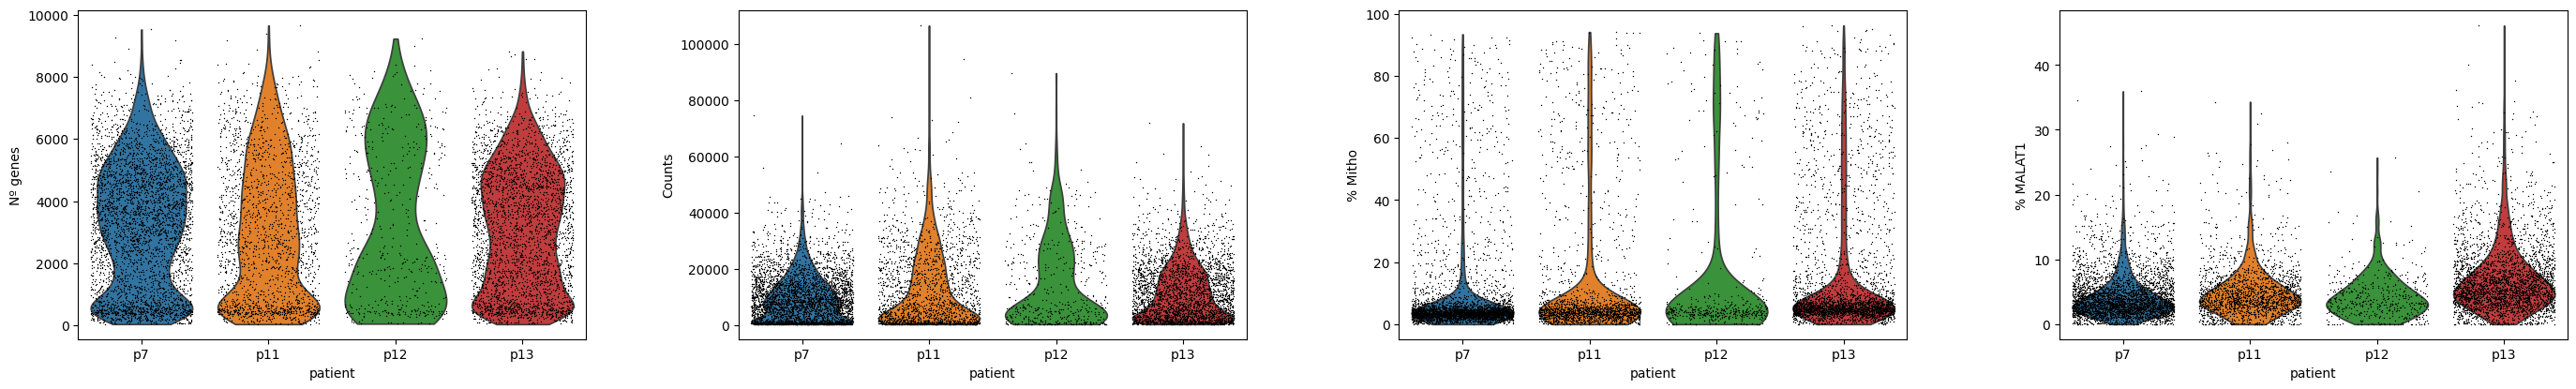

In [4]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["Malat"] = adata.var_names.str.startswith("MALAT1")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "Malat"], inplace=True, percent_top=None, log1p=True
)
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_Malat"],
    groupby="patient",
    jitter=0.4,
    multi_panel=True,
    ylabel = ["Nº genes", "Counts", "% Mitho", "% MALAT1"]
)

To establish some kind of guidance on what variables you should focus when performing a quality control, follow this basic rules:

- Total genes and counts: These two variables are closely correlated and you can apply a threshold on one of them or both if you like. Tipically, cells showing a large number of genes or counts are probabbly stressed. So, you want get rid of the cells that are on the top part of the graphs. In this case, we will discard cells that have more than 30.000 counts since we can see that above this arbitrary threshold there are fewer cells and they seem to be more extreme than the others for all groups. You can apply a different threshold or even apply a threshold for each patient if you think that is more accurate. 

- Another important aspect in total genes is that, as a rule of thumb, cells that are not expressing at least 200 different Nº genes are probably not a cell (empty droplet) and we will get rid of them as well. 

- Mithocondrial transcripts:  In a normal cell, we should expect between 5% to 20% of mithocondrial genes depending on the celltype. A high percentage of mitocondrial transcrits could mean that the cells have experienced stress or they are simply going through apoptosis due to the scRNA-seq process. These cells are not going to be representative of their type since they are experiencing changes in their gene expression and therefore are "Bad quality" cells. In the second and fourth graph below we can see that the vast majority of the cells concentrate in the lower part of the graph and have less than 12% of mithocondrial transcripts, which is where we will stablish our threshold.

- Malat: For this analysis we wanted to include a non-typical quality metric to show that you can customize this filtering as much as you want. There are plenty of different metrics and tools that you can use for filtering "bad" results from this type of data and whenever you think that a more accurate filtering is needed we encourage you to use it. In this case we will use Malat to better filter empty droplets. MALAT1 is a nlcRNA that is mostly present in the nucleous. It is useful to determine the nuclear fraction of RNA present since it has a very strong correlation with it (Montserrat-Ayuso et al.). We would tipically expect from 5%-40% of MALAT1 in the cell, which means that cells with really low percentages of MALAT1 are probably lacking a nucleous and therefore we can consider them to be empty droplets. In this case, we will discard the ones that have less than 1% to be extra sure that we are not deleting relevant information (such as cells with a small nucleous).

Apart from filtering cells based on the quality metrics, and in order to reduce the complexity of the analysis, we can filter the genes that are expressed in really small groups of cells. Have in mind that if you want to identify groups of cells that are really low, this may impact it since if you are filtering genes expressed in small groups of cells you wont detect these groups. In this case we will set the treshold in less than 3 cells expressing a gene.

Also, this is a step that you can revisit as many times as you need in order to produce a better quality results. Stablishing a threshold for all thses metrics is a process of trial and error, so don't hesitate to change it when you reach the downstream results.

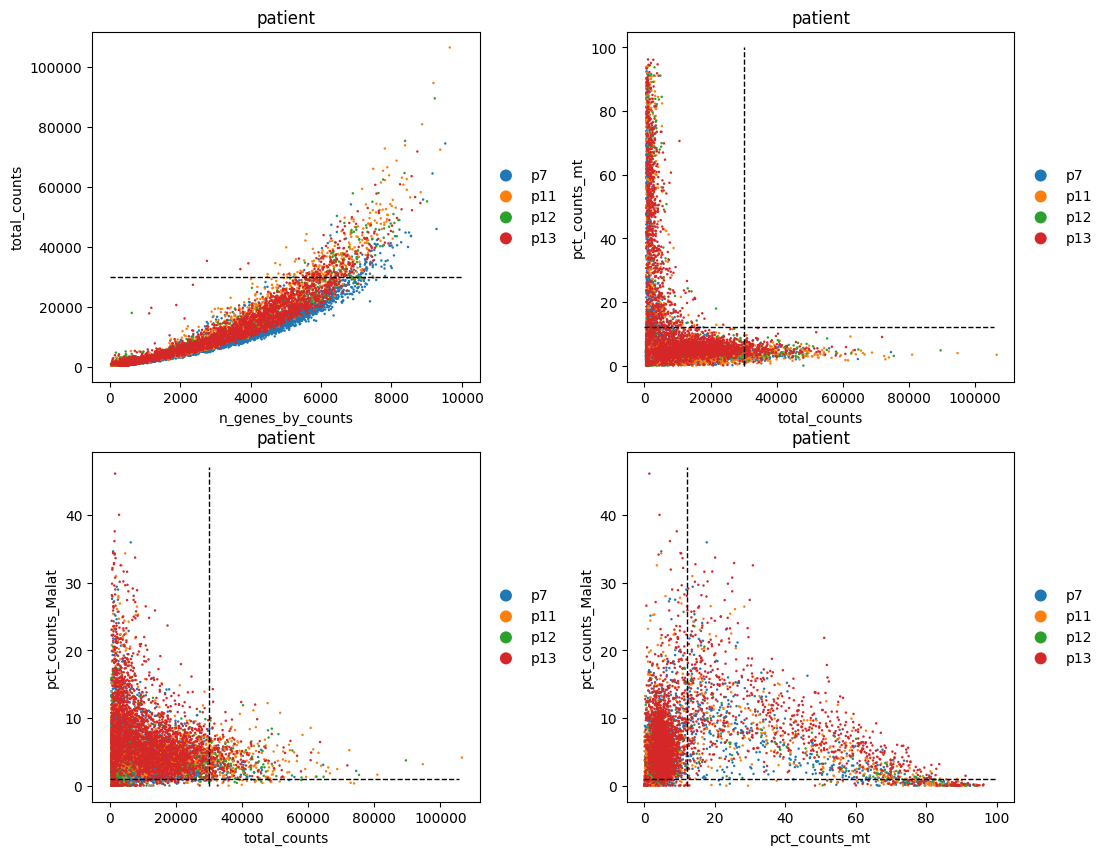

In [5]:
ncols = 2
nrows = 2
figsize = 5
wspace = 0.38
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
axs[0,0].hlines(30000, 0, 10000, colors="black", linestyle="dashed", linewidths=1)
axs[0,1].hlines(12, 0, 105700, colors="black", linestyle="dashed", linewidths=1)
axs[0,1].vlines(30000, 0, 100, colors="black", linestyle="dashed", linewidths=1)
axs[1,0].hlines(1, 0, 105700, colors="black", linestyle="dashed", linewidths=1)
axs[1,0].vlines(30000, 0, 47, colors="black", linestyle="dashed", linewidths=1)
axs[1,1].hlines(1, 0, 100, colors="black", linestyle="dashed", linewidths=1)
axs[1,1].vlines(12, 0, 47, colors="black", linestyle="dashed", linewidths=1)
sc.pl.scatter(adata, "n_genes_by_counts", "total_counts", color="patient", ax=axs[0,0], show=False)
sc.pl.scatter(adata, "total_counts", "pct_counts_mt", color="patient", ax=axs[0,1], show=False)
sc.pl.scatter(adata, "total_counts", "pct_counts_Malat", color="patient", ax=axs[1,0], show=False)
sc.pl.scatter(adata, "pct_counts_mt", "pct_counts_Malat", color="patient", ax=axs[1,1])

**The dashed lines show where the data will be cut*

In [6]:
# filtering cells with less than 200 genes
sc.pp.filter_cells(adata, min_genes=200)
# filtering genes expressed in less than 3
sc.pp.filter_genes(adata, min_cells=3) 
# filtering cells that have more than 30000 transcripts
adata = adata[adata.obs.total_counts < 30000, :] 
# filtering cells that have more than 10% of mithocondrial genes
adata = adata[adata.obs.pct_counts_mt < 12, :] 
# filtering cells that have less than 1% of MALAT1
adata = adata[adata.obs.pct_counts_Malat > 1, :]

filtered out 209 cells that have less than 200 genes expressed
filtered out 7698 genes that are detected in less than 3 cells


#### Cell cycle

Another part that may be interesting to have a look at, is the cell cycle where the cells are. To understand a bit better how it works, the cell cycle starts with the G1 phase where the cell is active, the S phase where the DNA duplicates and the G2/M phases where the cell prepares to divide (G2) and divide through mitosis (M) (Cooper 2000). During these phases, the cell has a different cell expression and this may interfere with the interpretation of the data in the downstream analysis. This may add another layer of information to better understand why the data is behaving as it is and it depends to the investigator if leaving it or try to extract this bias. In this case we will keep the information so that we can better interpret our final results.

In [7]:
converter = ec.EnsemblConverter() # object to convert Ensembl gene names to Symbol
cell_cycle_genes = pd.read_csv("https://raw.githubusercontent.com/hbc/tinyatlas/master/cell_cycle/Homo_sapiens.csv")
s_genes = converter.convert_ids(cell_cycle_genes[cell_cycle_genes["phase"] == "S"]["geneID"])["Symbol"].to_list()
g2m_genes = converter.convert_ids(cell_cycle_genes[cell_cycle_genes["phase"] == "G2/M"]["geneID"])["Symbol"].to_list()
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes , g2m_genes=g2m_genes)
adata.obs.head()

calculating cell cycle phase
computing score 'S_score'
    finished (0:00:00)
computing score 'G2M_score'


d:\Datos de usuario\Desktop\Single Cell Analysis\Glioblastoma (GSE214966)\Glioblastoma-GSE214966\.venv\Lib\site-packages\scanpy\tools\_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


    finished (0:00:00)


,patient,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_Malat,log1p_total_counts_Malat,pct_counts_Malat,n_genes,S_score,G2M_score,phase
AAACCCAAGTACAGAT-1_p7,p7,329,5.799093,503.0,6.222576,16.0,2.833213,3.180914,22.0,3.135494,4.373757,329,-0.052427,-0.037200,G1
AAACCCATCCGATCTC-1_p7,p7,7566,8.931552,29088.0,10.278115,1042.0,6.949856,3.582233,340.0,5.831882,1.168867,7566,2.633281,2.888726,G2M
AAACCCATCTAGTACG-1_p7,p7,5362,8.587279,17782.0,9.785998,763.0,6.638568,4.290856,1072.0,6.978214,6.028568,5362,1.791872,-0.355925,S
AAACGAAGTACCTATG-1_p7,p7,6098,8.715880,20138.0,9.910414,806.0,6.693324,4.002384,370.0,5.916202,1.837322,6098,2.578189,0.989953,S
AAACGAAGTGTTTACG-1_p7,p7,4302,8.367068,10262.0,9.236300,376.0,5.932245,3.664003,204.0,5.323010,1.987917,4302,1.422849,0.115890,S


#### Cancer cells detection

Finally, before starting the preprocessing of the data and since we are working with cancer cells, we have to aknowledge the fact that not all cells in a tumour are cancer cells. This is normally acomplished in the analysis downstream having a look on the marker genes and identifying cancer genes that are overexpressed in the diferent clusters. It is a very manual step that requires some knowledge of the data that you are working with since different cancers may have different marker genes. In this pipeline we will not do that but in part 2 of this analysis we will have a look into it.

In this analysis we want to test a newly developed software named "Cancer-Finder" (Zhong et al 2024) that is capable to identify cancer cells based on the expression matrix using a Neural Network algorithm. According to the authors, it has a ~95% of accuracy on most samples. We will compare the results of this software to the classification that the original paper does in this regard.

In order to use it we well have to follow the instructoins on the github page https://github.com/Patchouli-M/SequencingCancerFinder/tree/master (consulted on 09/Oct/2024) 
- First, we will save our expression matrix as a .csv file as follows

In [8]:
counts = pd.DataFrame(adata.X.todense()).T
counts.columns=adata.obs.index.to_list()
counts.insert(0, column="Symbol", value=adata.var.index.to_list())
counts.to_csv("D:/Datos de usuario/Desktop/Single Cell Analysis/Glioblastoma (GSE214966)/Data/Matrix.csv", header=True, index=False)


- Next, we will have to download the pretrained model from the same github page ("model_epoch92.pkl", although it would be best to clone the repository)
- Finally we can run the "infer.py" program in our terminal supplying the model we download, our expression matrix and the place where the output should go. In this case we used the following code. You will have to adjust the paths to the actual files. but roughly it would be : path/to/infer.py --ckp = path/to/model_epoch92.pkl -- matrix = "path/to/matrix.csv" --out = "path/to/outputfolder"

`C:/Users/Ferran/anaconda3/envs/py3.12.6/python.exe "d:/Datos de usuario/Desktop/Single Cell Analysis/1. Other Githubs/Cancer_finder/infer.py" --ckp="d:/Datos de usuario/Desktop/Single Cell Analysis/1. Other Githubs/Cancer_finder/model_epoch92.pkl" --matrix="d:/Datos de usuario/Desktop/Single Cell Analysis/Glioblastoma (GSE214966)/Data/Matrix.csv" --out="d:/Datos de usuario/Desktop/Single Cell Analysis/Glioblastoma (GSE214966)/Results/CFresult.csv"`

There are options to train your own model but in this case we will use the one pretrained.

Once the program has finished, we will read the output and merge it to our metadata.

In [9]:
rescan = pd.read_csv("CFresult.csv", names=["sample", "scf_predict"])
rescan["scf_predict"] = np.where(rescan["scf_predict"] == "1.0", 'Cancer cell', 'Normal cell')
merged = pd.merge(adata.obs, rescan, "left", left_index=True, right_on="sample")
merged.set_index("sample", inplace=True)
adata.obs = merged.copy()


#### Preprocessing

Now we will begin preprocessing the data so that we can do dimensionality reductions and be able to interpret it. There are a few things to take in consideration here.
- Normalizing the data stablishes 0 as the median for each gene so that you have positive and negative values for the expressions that are above and below the median expression.
- Logarithmize makes the data have a normal distribution
- Filtering genes that have log(counts + 1) > 3. We will consider these genes as "not beeing expresed"
- Identifying the most variable genes to work only with them. This will reduce the computational stress and significantly increase the speed of the analysis only losing very little information
- Either a large expression of genes or mitocondrial genes may affect the ratios of the other gene expressions in a cell. To account for that we will perform a regression to extract that bias
- Finally, we can perform a dimensional reduction using Principal components analysis (PCA)
- Once the PCA is done, we will integrate the data. In this case we have used `Harmony` software to integrate the different samples together. 

In [10]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# lognormalize to have normal distribution
sc.pp.log1p(adata)
# filter genes that have log(counts+1) < 3 (as non expressed)
sc.pp.filter_genes(adata, min_counts=3) 
# high variable genes 
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
# regression out variables that may be affecting biasing our data
sc.pp.regress_out(adata, ["pct_counts_mt", "total_counts", "n_genes_by_counts"])
# scale data
sc.pp.scale(adata, max_value=10)
# Princial Component Analysis
sc.tl.pca(adata)
# integration of the different samples
sc.external.pp.harmony_integrate(adata, "patient")
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
adata.var

normalizing counts per cell
    finished (0:00:00)
filtered out 2271 genes that are detected in less than 3 counts
extracting highly variable genes
    finished (0:00:00)
regressing out ['pct_counts_mt', 'total_counts', 'n_genes_by_counts']


... storing 'phase' as categorical
... storing 'scf_predict' as categorical


    sparse input is densified and may lead to high memory use
    finished (0:03:07)
computing PCA
    with n_comps=50
    finished (0:00:03)


2025-02-10 16:01:27,891 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-02-10 16:01:29,210 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-02-10 16:01:29,260 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-02-10 16:01:30,801 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-02-10 16:01:32,324 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-02-10 16:01:33,887 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-02-10 16:01:35,443 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-02-10 16:01:37,071 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-02-10 16:01:38,471 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-02-10 16:01:39,684 - 

,gene_ids,feature_types,mt,Malat,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,n_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
AL627309.1,ENSG00000238009,Gene Expression,False,False,37,0.003873,0.003866,99.612687,37.0,3.637586,37,17.739786,False,0.003859,0.238555,-0.963326,6.657797e-17,0.043491
AL627309.3,ENSG00000239945,Gene Expression,False,False,11,0.001151,0.001151,99.884853,11.0,2.484907,11,3.577726,False,0.000664,-0.471551,-2.018321,-8.153225e-17,0.015644
AL669831.5,ENSG00000237491,Gene Expression,False,False,1162,0.150529,0.140222,87.836282,1438.0,7.271704,1161,649.058960,False,0.147806,0.960391,0.109096,-4.837913e-15,0.265631
FAM87B,ENSG00000177757,Gene Expression,False,False,43,0.004815,0.004804,99.549880,46.0,3.850147,43,18.414198,False,0.003773,0.038375,-1.260731,-2.954800e-16,0.041104
LINC00115,ENSG00000225880,Gene Expression,False,False,382,0.042604,0.041722,96.001256,407.0,6.011267,382,207.282318,False,0.056242,1.541772,0.972847,-8.897881e-16,0.170332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,ENSG00000273748,Gene Expression,False,False,174,0.018947,0.018770,98.178583,181.0,5.204007,174,90.946991,False,0.021241,0.628473,-0.384031,6.125946e-16,0.104577
AC007325.4,ENSG00000278817,Gene Expression,False,False,535,0.062703,0.060815,94.399665,599.0,6.396930,535,248.113739,False,0.051439,0.228580,-0.978146,-5.035715e-15,0.150304
AC007325.2,ENSG00000277196,Gene Expression,False,False,104,0.011201,0.011138,98.911337,107.0,4.682131,104,51.907719,False,0.011042,0.176865,-1.054978,-8.548250e-16,0.072218
AL354822.1,ENSG00000278384,Gene Expression,False,False,479,0.056422,0.054888,94.985868,539.0,6.291569,479,207.042389,False,0.047799,0.883193,-0.005595,1.217102e-14,0.152176


#### Neighbours, UMAP and clustering

At this point, we will start the clustering analysis and visualising our data. Normally at this step youd like to run the function `sc.tl.leiden` with the default options but, to have a deeper look into the clustering, we will use a higher resolution additionally so we have a more detailed clustering later in the analysis.

In [11]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1, flavor="leidenalg", n_iterations=2, key_added="leiden")


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:07)
computing UMAP
    finished (0:00:11)
running Leiden clustering


C:\Users\Ferran\AppData\Local\Temp\ipykernel_5540\3110167052.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1, flavor="leidenalg", n_iterations=2, key_added="leiden")


    finished (0:00:00)


### Preliminary Results

In these first UMAPS that we are going to show, we want to analyse the overall result that we have achieved until now and some additional processes that we can add to have a better understanding of the data.

#### Integration

Here well try to understand the integration of the data. 

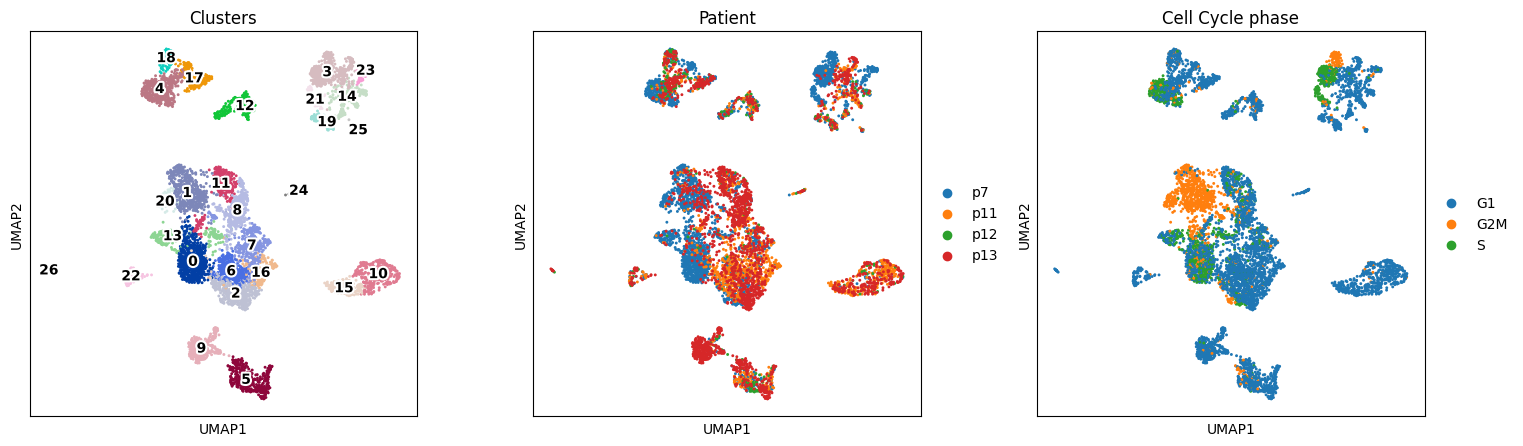

In [12]:
ncols = 3
nrows = 1
figsize = 5
wspace = 0.3
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
sc.pl.umap(adata, color=["leiden"], title=["Clusters"], ax=axs[0], show=False, legend_loc="on data", legend_fontoutline=3)
sc.pl.umap(adata, color=["patient"], title=["Patient"], ax=axs[1], show=False)
sc.pl.umap(adata, color=["phase"], title=["Cell Cycle phase"], ax=axs[2])


As we can see in the above result, integration of this data is quite off. 

Looking at the patient annotation, there can be seen a clear separation between the two major donnors (p7 and the rest) in the central clusters but also in the upper ones. This is also particularly critical since a lot of of the identified clusters have a majority of one or another patient, which is not what we want here. Normally in this case we would search for an alternative way to integrate data and see if the approach of the new algorithm can solve the problem. We tried to do it using ``Bbknn`` algorithm the results were actually worse. 

If we look now into the cell cycle phase in the third graphic, we can se that most of this separations that we see in patients are also in the cell cycle. In fact, it seems that patient 7 is the one causing this separation as the vast majority of cells in cycles G2M and S are from this donnor, although not exclusively. This is a difficult problem to solve since there is no much information on how the samples were managed on the original papaer and the differences for each patient (age, sex, mutations, ...) doesn't really explain the separation we have here.

We also tried to integrate the cell cycle effects (data not shown) but the integration was not good either. This difficulties in the integration process is probably due to some variable/s that we dont know yet and are affecting the different patients but we will try to discover them as we advance in this analysis. For now we will leave this data as it is. In a different analysis we will try to go into more detail in order to annotate each cell type in this data.



#### Cancer-Finder prediction

This is the classification performed by Cancer Finder shown on the UMAP

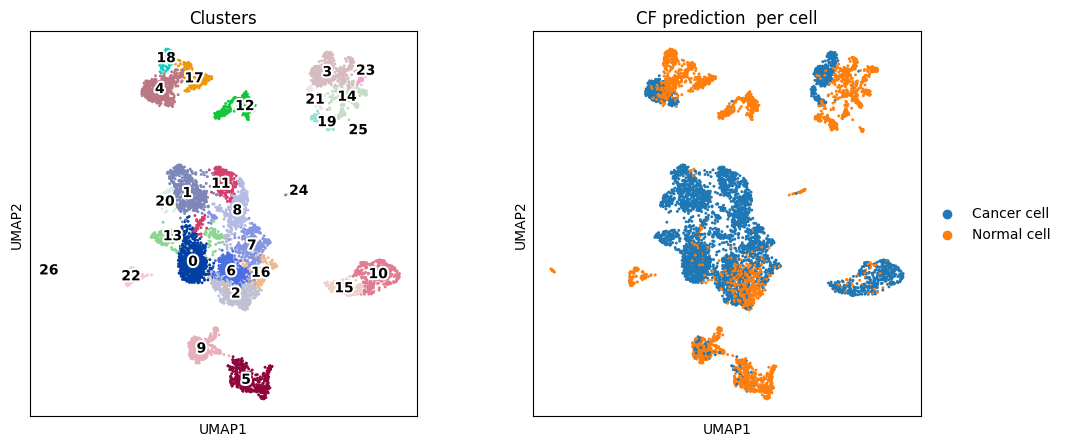

In [13]:
ncols = 2
nrows = 1
figsize = 5
wspace = 0.3
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
sc.pl.umap(adata, color=["leiden"], title=["Clusters"], ax=axs[0], show=False, legend_loc="on data", legend_fontoutline=3)
sc.pl.umap(adata, color=["scf_predict"], title=["CF prediction  per cell"], ax=axs[1])



As we can se in the graphic above, there are a few clusters that are fully populated by cell labelled as cancer by Cancer-Finder. But, we can also see that there are others that have a mix of both (Clusters 2, 9, 11 and 12). Cancer finder identifies cell by cell based on the cell gene expression so this classification may be a little bit messy when compared to the clustering. In order to reduce complexity we will create a new variable labelling each cluster with the majority cell type that has been identified (cancer and normal). This will give us a cleaner view on the UMAP keeping in mind that the true classification is cell by cell, not by cluster.

... storing 'scf_predict_clust' as categorical


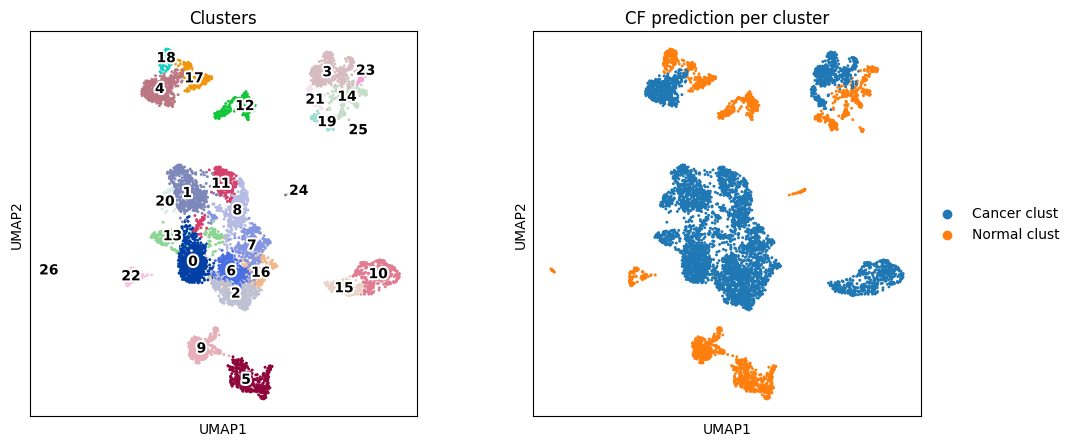

In [14]:
dct = {}
for clust in adata.obs["leiden"].unique().tolist():
    if (Counter(adata.obs[adata.obs["leiden"] == clust]["scf_predict"]).most_common()[0][0] == "Cancer cell"):
        dct[clust] = "Cancer clust"
    else:
        dct[clust] = "Normal clust"
# NA cells will be considered "Normal cell"

adata.obs["scf_predict_clust"] = [dct[cell_clust] for cell_clust in adata.obs["leiden"].to_list()]

ncols = 2
nrows = 1
figsize = 5
wspace = 0.3
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
sc.pl.umap(adata, color=["leiden"], title=["Clusters"], ax=axs[0], show=False, legend_loc="on data", legend_fontoutline=3)
sc.pl.umap(adata, color=["scf_predict_clust"], title=["CF prediction per cluster"], ax=axs[1])


As we can see in the above graphic, the annotation is much more cleaner and can be intuitively interpreted. Cancer-Finders seems to identify a big cluster of cancer cells in the middle of the data, while there are some periferic clusters that are both a mix of malignant cells and normal cells. This is really interesting since it may indicate that those are cells are related in a way. It could be that they are normal cells that evolve to cancer cells or maybe could be that these cells share some kind of functions, and therefore gene expressions, but we will analyse this in another pipeline. For now, we have our alternative method of comparison done.

#### Infer CNV annotations

Now we can start our method of reference for this analysis. 

In this analysis we are using python as our programming language and the auhors of the paper used R as their language. Luckly it exists the pachage ``infercnvpy`` which is based on the ``infercnv`` R package. This package uses the genomic chromosomes of the expressed genes to mapp the positional expression variability in the genome. As stated in the introduction, cancer rearranges the genome of the cells that it is affecting and  this causes the cell to change their gene expression. by tracking this changes we can infer which cells are actually beeing affected by cancer.

The first step in this method is to retrieve the genomic positions of the genes extressed in our data. To do that we will use the Biomart database.

In [15]:
# Retrieve gene symbols
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
        use_cache=False
    ).set_index("ensembl_gene_id")
# rename some columns
annot.rename(columns={"start_position" : "start", "end_position" : "end", "chromosome_name" : "chromosome"}, inplace=True)
chroms = str(np.arange(1,24))
exclude = ["chr" + value for value in annot["chromosome"].unique() if value not in chroms]
annot["chromosome"] = ["chr" + value if value in chroms else value for value in annot["chromosome"]]

# NOTE: sometimes there are server problems and this gives an error. Try again in a few minutes.

In [16]:
# erasing cols to be able to rerun this chunk
adata.var.drop(labels=["ensembl_gene_id", "chromosome", "start", "end", "external_gene_name"], axis=1, inplace=True, errors="ignore")
adata.var["index"] = adata.var.index
# merging with adata.var
adata.var = adata.var.merge(annot, how="left", left_on="gene_ids", right_on="ensembl_gene_id", )
adata.var.set_index("index", inplace=True)
adata.var

,gene_ids,feature_types,mt,Malat,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,...,highly_variable,means,dispersions,dispersions_norm,mean,std,external_gene_name,start,end,chromosome
index,,,,,,,,,,,,,,,,,,,,,
AL627309.1,ENSG00000238009,Gene Expression,False,False,37,0.003873,0.003866,99.612687,37.0,3.637586,...,False,0.003859,0.238555,-0.963326,6.657797e-17,0.043491,NaN,NaN,NaN,NaN
AL627309.3,ENSG00000239945,Gene Expression,False,False,11,0.001151,0.001151,99.884853,11.0,2.484907,...,False,0.000664,-0.471551,-2.018321,-8.153225e-17,0.015644,NaN,89551.0,91105.0,chr1
AL669831.5,ENSG00000237491,Gene Expression,False,False,1162,0.150529,0.140222,87.836282,1438.0,7.271704,...,False,0.147806,0.960391,0.109096,-4.837913e-15,0.265631,LINC01409,778739.0,810066.0,chr1
FAM87B,ENSG00000177757,Gene Expression,False,False,43,0.004815,0.004804,99.549880,46.0,3.850147,...,False,0.003773,0.038375,-1.260731,-2.954800e-16,0.041104,FAM87B,817363.0,819842.0,chr1
LINC00115,ENSG00000225880,Gene Expression,False,False,382,0.042604,0.041722,96.001256,407.0,6.011267,...,False,0.056242,1.541772,0.972847,-8.897881e-16,0.170332,LINC00115,586945.0,827989.0,chr1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,ENSG00000273748,Gene Expression,False,False,174,0.018947,0.018770,98.178583,181.0,5.204007,...,False,0.021241,0.628473,-0.384031,6.125946e-16,0.104577,NaN,54224.0,83311.0,GL000219.1
AC007325.4,ENSG00000278817,Gene Expression,False,False,535,0.062703,0.060815,94.399665,599.0,6.396930,...,False,0.051439,0.228580,-0.978146,-5.035715e-15,0.150304,NaN,131494.0,137392.0,KI270734.1
AC007325.2,ENSG00000277196,Gene Expression,False,False,104,0.011201,0.011138,98.911337,107.0,4.682131,...,False,0.011042,0.176865,-1.054978,-8.548250e-16,0.072218,NaN,138082.0,161852.0,KI270734.1


100%|██████████| 2/2 [00:18<00:00,  9.37s/it]


computing PCA
    with n_comps=50


d:\Datos de usuario\Desktop\Single Cell Analysis\Glioblastoma (GSE214966)\Glioblastoma-GSE214966\.venv\Lib\site-packages\scanpy\tools\_utils.py:41: UserWarning: You’re trying to run this on 16771 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


    finished (0:00:06)
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


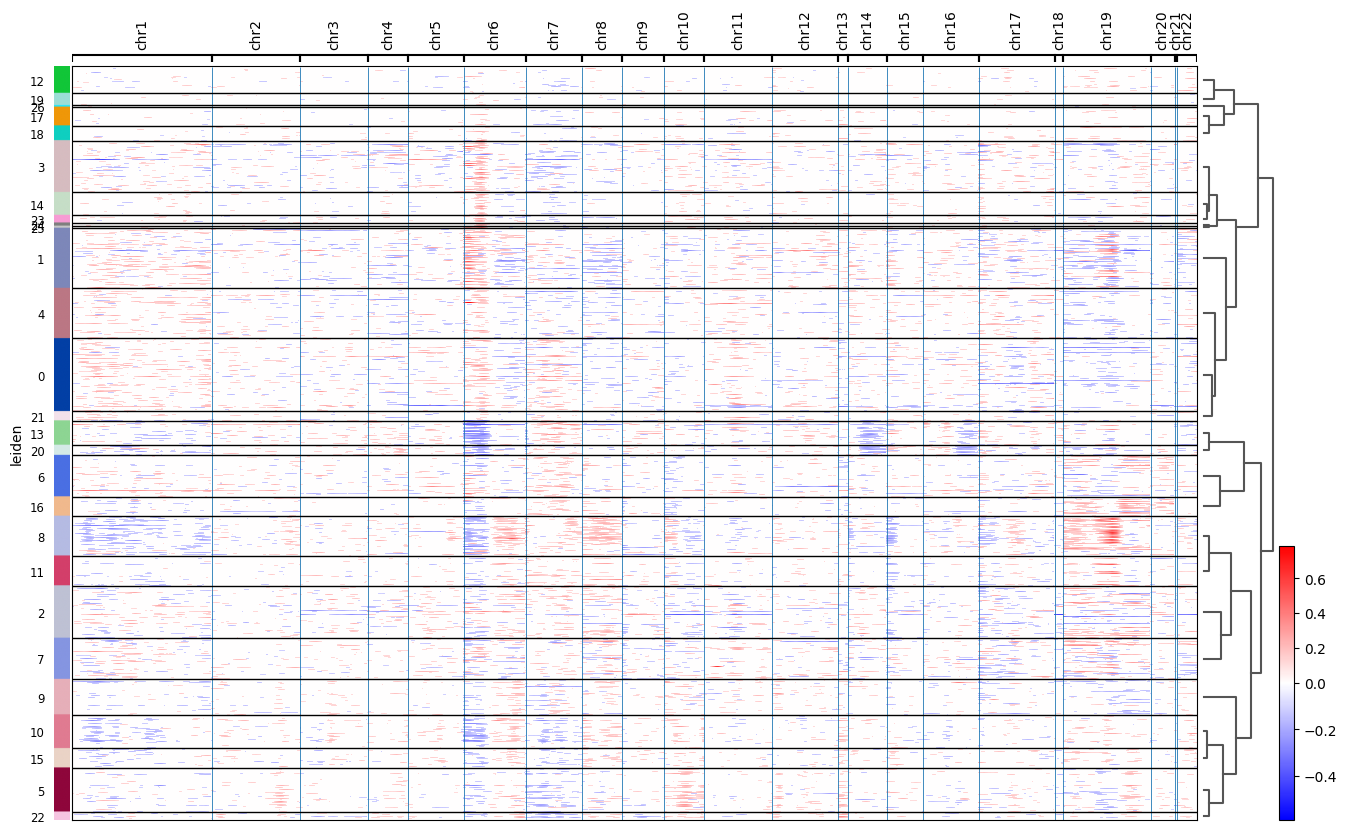

In [17]:
# running infercnv main function
cnv.tl.infercnv(adata, step=1, window_size=250, exclude_chromosomes=exclude)
# creating the heatmap with the positional expresion
cnv.pl.chromosome_heatmap(adata, groupby="leiden", dendrogram=True)

This is the main result of this package. As we can see the red and blue markings show us the changes in the gene expression along all the genome for the cells in this data and they may not be as clear water but we can see that there are some interesting parts. The first thing that comes to mind is that half of the chromosome 6 seems to be affected by this changes of expression, most heavily on clusters 13 and 8 but also on 1 and 10. There are other chromosomes that are affected by this such as chromosomes 1, 7, 8, 10, 14 or 19 and probably more in different clusters. looking at the cluster classification, there are no clusters that actually have major aberrations such as full duplicated or deleted chromosomes. Knowing that the integration of the data was not really the best, we also expected to see here a separation between clusters that could be compared to the UMAPs we saw on the Cell Cycle. It could have been interesting to see similarities in those classifications but this data doesn't make a lot of sense to me.   

This diversity in results is somethinng that we can expect from glioblastoma cells. This type of malignant cells can come from different origins and given that we have seen some differences on how this data is clustiring across patients in the UMAPs we can argue that probably these diferences is what we are also seeing here. 

To try an have a better 'numerical' result, ``infercnvpy`` have the cnv_score to calculate a numerical value to distinguish between them. 


... storing 'external_gene_name' as categorical
... storing 'chromosome' as categorical


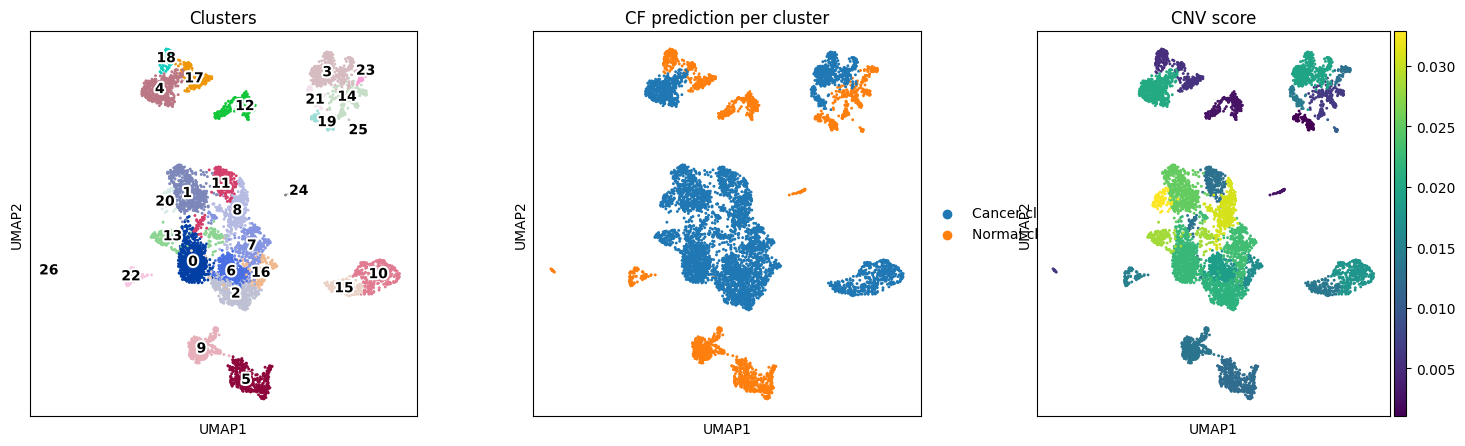

In [18]:
# Calculating the score
cnv.tl.cnv_score(adata, groupby="leiden")

ncols = 3
nrows = 1
figsize = 5
wspace = 0.3
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
sc.pl.umap(adata, color=["leiden"], title=["Clusters"], ax=axs[0], show=False, legend_loc="on data", legend_fontoutline=3)
sc.pl.umap(adata, color=["scf_predict_clust"], title=["CF prediction per cluster"], ax=axs[1], show=False)
sc.pl.umap(adata, color=["cnv_score"], title=["CNV score"], ax=axs[2])

In these last figures is where we can see the final classification from one method and the other. Comparing Cancer Finder to the CNV method there are not really a clear way to visually evaluate the differences in malignancy. Most of the clusters have a very similar score and there is no great gap between all of them that let us distinguish between two grat groups, i.e. Malignant and normal clusters. But what we can do is ordering clusters by cnv score. 

In [19]:
adata.obs.drop_duplicates(subset=['leiden']).loc[:,['leiden', 'cnv_score', 'scf_predict_clust']].sort_values('cnv_score').style.hide(axis="index")

leiden,cnv_score,scf_predict_clust
19,0.001010,Normal clust
24,0.002452,Normal clust
12,0.002526,Normal clust
18,0.005282,Normal clust
17,0.005601,Normal clust
26,0.006421,Normal clust
14,0.006424,Normal clust
25,0.010263,Normal clust
5,0.012140,Normal clust
23,0.012834,Normal clust


As it can be seen in the above table, the Cancer-Finder results doesn't aligns with the cnv_score so that we can stablish a threshold to separate malignant clusters and non-malignant. Following this finding we can argue that the inference from CNVs in RNA sequencing doesn't always show clear results although we can see in the table that extreme values of cnv_score does show a difference in Cancer finder annotation. One of the things that has bothered me about ``infercnvpy`` package is that it doesn't include any way to establish this threshold other than by experience or external help and in some cases, like this one, results are not really easy to interpretate, so having Cancer-Finder, or any external classification,  is crucial to be able to annotate the samples without beeing an expert.

On the other hand, being glioblastoma a very diverse and heterogenous type of cancer, ``infercnv`` is able to help you to understand which chromosomes are affected in the different clusters and would probably help to identify cells that have the same origin, as they would incorporate the same genomic aberrations. In a future pipeline, we will try to develop a more acurate annotation of the cells including the cell type annotation so that we can fully understand this data. For now, this is everything that we wanted to acomplish in this analysis an we will leave it here.

## Conclusions

Annotation of cells in a scRNA-seq analysis is one of the most difficult processes to do accurately and could have a major impact the downstream analysis if not done well enough. In this small analysis we have focused in the annotation of malignancy in a glioblastoma dataset, using two different methods. Our results show that this two methods doesn't align perfectly, but there is no clear evidence that both methods aren't accurate. From the figures that we have shown here, CNV analysis doesen't provide a clear visualization on the malignancy, because only shows a partial information on the genome (using the RNA) and Cancer finder, although it claims that has a high accuraccy in detecting cancer cells, doesn't really aligns with CNV results, which has been used more extensively across the scientific community.

When using both methods combined we can argue that the classification has a better resolution since now we can actually order all the clusters and stablish a threshold but there are still 5 clusters "in the middle ground" to beeing verifyed by the two methods. Although this is and will be a challenge for scientists, this analysis is indicating that the classification is full of greys and by having a black-whithe annotation we are loosing most of the information. As said before, Glioblastoma is a very complex type of data that need a lot of experience to be able to understand and interpret the results obtained. In my next analysis we will be trying to uncover more information about this data and its particularities


# Bibliography

- Cooper GM. The Cell: A Molecular Approach. 2nd edition. Sunderland (MA): Sinauer Associates; 2000. The Eukaryotic Cell Cycle. Available from: https://www.ncbi.nlm.nih.gov/books/NBK9876/

- Tickle T, Tirosh I, Georgescu C, Brown M, Haas B (2019). inferCNV of the Trinity CTAT Project.. Klarman Cell Observatory, Broad Institute of MIT and Harvard, Cambridge, MA, USA. https://github.com/broadinstitute/inferCNV.

- Ahsan, H., Asghar, M., & Malik, S. I. (2024). Potential diagnostic and drug target markers in glioblastoma. Scientific Reports, 14(1). https://doi.org/10.1038/s41598-024-57752-1

- Montserrat-Ayuso, T., & Esteve-Codina, A. (n.d.). Revealing the Prevalence of Suboptimal Cells and Organs in Reference Cell Atlases: An Imperative for Enhanced Quality Control. https://data.humancellatlas.org/

- Lee, S., Weiss, T., Bühler, M., Mena, J., Lottenbach, Z., Wegmann, R., Sun, M., Bihl, M., Augustynek, B., Baumann, S. P., Goetze, S., van Drogen, A., Pedrioli, P. G. A., Penton, D., Festl, Y., Buck, A., Kirschenbaum, D., Zeitlberger, A. M., Neidert, M. C., … Snijder, B. (2024). High-throughput identification of repurposable neuroactive drugs with potent anti-glioblastoma activity. Nature Medicine. https://doi.org/10.1038/s41591-024-03224-y

In [ ]:
# adata.write_h5ad("D:/Datos de usuario/Desktop/Single Cell Analysis/Glioblastoma (GSE214966)/Objects/GSE214966_canannot_s1.h5ad")